### classify_insect_std_20200806

In [1]:
import h5py
from sklearn.mixture import GaussianMixture as GMM
import numpy as np
from os import getcwd as cwd
from os.path import join as pj
import matplotlib.pyplot as plt
%matplotlib inline

# evaluation
from evaluation.classification.statistics import get_size_list_from_xte

In [2]:
def get_insect_size_dic(X, Y, lbl_to_name):
    """
        get dictionary of label to size
        Args:
            - X: np.array, shape==[insect_num, height, width, channels]
            - Y: np.array, shape==[insect_num]
            - lbl_to_name: dict, {label: label_name}
    """
    X_size = np.array(get_size_list_from_xte(X))
    insect_size_dic = {}
    for i in range(len(lbl_to_name)):
        insect_filter = Y == i
        filtered_X_size = X_size[insect_filter]
        filtered_X_size = np.sort(filtered_X_size)
        insect_size_dic.update({lbl_to_name[i]: filtered_X_size})
    return insect_size_dic

def gaussian(mu, sigma):
    """
        return gaussian distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    def f(x):
        return np.exp(-0.5 * (x - mu) ** 2 / sigma) / np.sqrt(2 * np.pi * sigma)
    return f

def laplace(mu, sigma):
    """
        return laplace distribution
        Args:
            - mu: np.array(dtype=float), shape=[K]
            - sigma: np.array(dtype=float), shape=[K]
    """
    b = np.sqrt(sigma / 2)
    def f(x):
        return 1 / (2 * b) * np.exp(-1 * np.abs(x - mu) / b)
    return f

In [3]:
lbl_to_name = {
    0: 'Diptera', 
    1: 'Ephemeridae', 
    2: 'Ephemeroptera', 
    3: 'Lepidoptera', 
    4: 'Plecoptera', 
    5: 'Trichoptera', 
}

In [4]:
all_data_path = pj(cwd(), "data/all_classification_data/classify_insect_std_20200806")
with h5py.File(all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]

In [5]:
insect_size_dic = get_insect_size_dic(X, Y, lbl_to_name)

In [6]:
def calc_mu_sigma(insect_size_dic):
    """
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu = []
    sigma = []
    for key, value in insect_size_dic.items():
        x = np.log2(insect_size_dic[key])
        gmm.fit(x.reshape(-1, 1))
        mu.append(gmm.means_.reshape([-1])[0])
        sigma.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu), np.array(sigma)

def plot_hist_and_distribution(x, seq, mu, sigma, label_name):
    """
        plot histgram and gaussian distribution
        Args:
            - x: np.array(dtype=float)
            - seq: np.array(dtype=float)
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - label_name: str
    """
    plt.hist(x, bins=100, density=True)
    plt.plot(seq, gaussian(mu, sigma)(seq), linewidth=2, color="red")
    plt.title(label_name)

In [7]:
mu, sigma = calc_mu_sigma(insect_size_dic)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu[key], sigma[key]))

name = Diptera: mu = 11.621745343986495, sigma = 1.7181926510995773
name = Ephemeridae: mu = 13.156389134540905, sigma = 0.6106979826352166
name = Ephemeroptera: mu = 10.989064618392351, sigma = 1.237532505380402
name = Lepidoptera: mu = 12.68085061426625, sigma = 1.2809743800315292
name = Plecoptera: mu = 11.38243516582298, sigma = 0.8049635620799064
name = Trichoptera: mu = 11.672449439591857, sigma = 0.8279052362708695


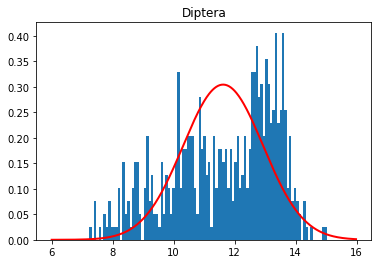

In [8]:
x = np.log2(insect_size_dic["Diptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[0], sigma[0], "Diptera")

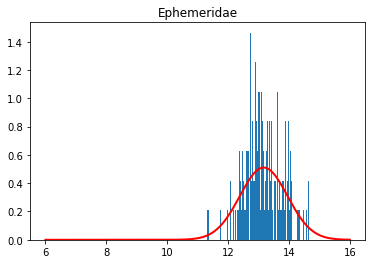

In [9]:
x = np.log2(insect_size_dic["Ephemeridae"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[1], sigma[1], "Ephemeridae")

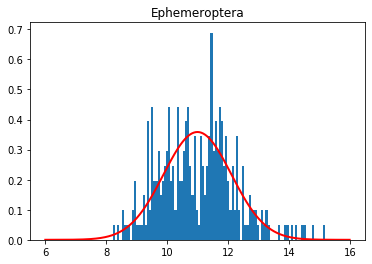

In [10]:
x = np.log2(insect_size_dic["Ephemeroptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[2], sigma[2], "Ephemeroptera")

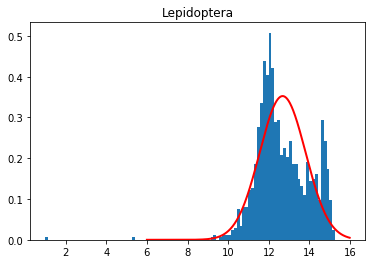

In [11]:
x = np.log2(insect_size_dic["Lepidoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[3], sigma[3], "Lepidoptera")

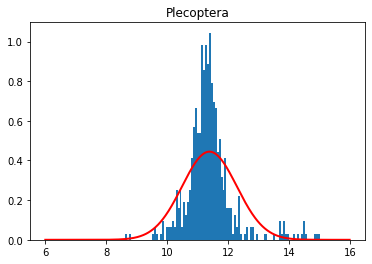

In [12]:
x = np.log2(insect_size_dic["Plecoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[4], sigma[4], "Plecoptera")

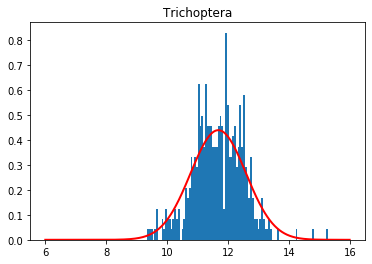

In [13]:
x = np.log2(insect_size_dic["Trichoptera"])
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x, seq, mu[5], sigma[5], "Trichoptera")

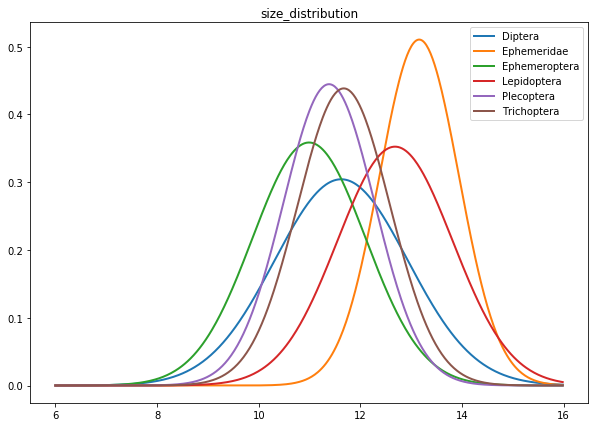

In [14]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu[0], sigma[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu[1], sigma[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu[2], sigma[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu[3], sigma[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu[4], sigma[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu[5], sigma[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()

### (1) normalize and sift mu

In [15]:
def normalize_and_sift_mu(insect_size_dic, mu, sigma, lbl_to_name):
    """
        keep mu and match sigma = 1
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - lbl_to_name: dict, {label: label_name}
    """
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu_converted = []
    sigma_converted = []
    for key, value in lbl_to_name.items():
        x = np.log2(insect_size_dic[value])
        x_convert = (x - mu[key]) / sigma[key]
        x_convert += mu[key]
        gmm.fit(x_convert.reshape(-1, 1))
        mu_converted.append(gmm.means_.reshape([-1])[0])
        sigma_converted.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu_converted), np.array(sigma_converted)

In [16]:
mu_converted, sigma_converted = normalize_and_sift_mu(insect_size_dic, mu, sigma, lbl_to_name)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.621745343986495, sigma = 1.000000330633913
name = Ephemeridae: mu = 13.156389134540904, sigma = 0.9999991593446854
name = Ephemeroptera: mu = 10.989064618392351, sigma = 1.0000001735198443
name = Lepidoptera: mu = 12.68085061426625, sigma = 1.0000001952882762
name = Plecoptera: mu = 11.38243516582298, sigma = 0.9999997283549432
name = Trichoptera: mu = 11.672449439591857, sigma = 0.9999997705277541


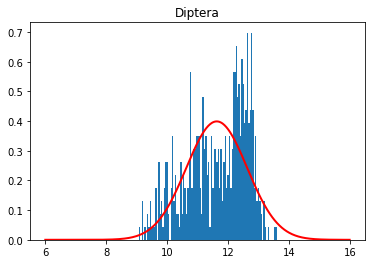

In [17]:
x = np.log2(insect_size_dic["Diptera"])
x_convert = (x - mu[0]) / sigma[0]
x_convert += mu[0]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[0], sigma_converted[0], "Diptera")

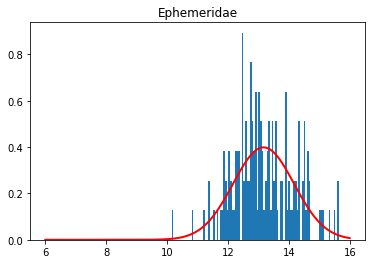

In [18]:
x = np.log2(insect_size_dic["Ephemeridae"])
x_convert = (x - mu[1]) / sigma[1]
x_convert += mu[1]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[1], sigma_converted[1], "Ephemeridae")

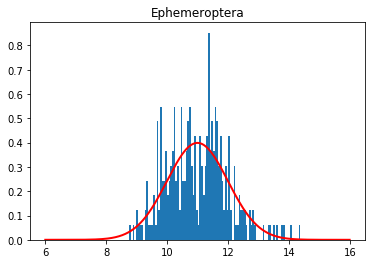

In [19]:
x = np.log2(insect_size_dic["Ephemeroptera"])
x_convert = (x - mu[2]) / sigma[2]
x_convert += mu[2]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[2], sigma_converted[2], "Ephemeroptera")

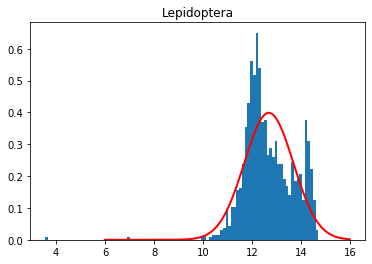

In [20]:
x = np.log2(insect_size_dic["Lepidoptera"])
x_convert = (x - mu[3]) / sigma[3]
x_convert += mu[3]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[3], sigma_converted[3], "Lepidoptera")

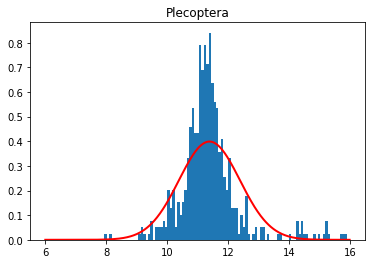

In [21]:
x = np.log2(insect_size_dic["Plecoptera"])
x_convert = (x - mu[4]) / sigma[4]
x_convert += mu[4]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[4], sigma_converted[4], "Plecoptera")

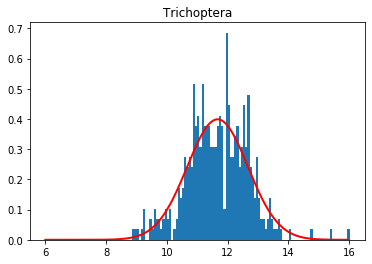

In [22]:
x = np.log2(insect_size_dic["Trichoptera"])
x_convert = (x - mu[5]) / sigma[5]
x_convert += mu[5]
seq = np.arange(6.0, 16.0, 0.02)
plot_hist_and_distribution(x_convert, seq, mu_converted[5], sigma_converted[5], "Trichoptera")

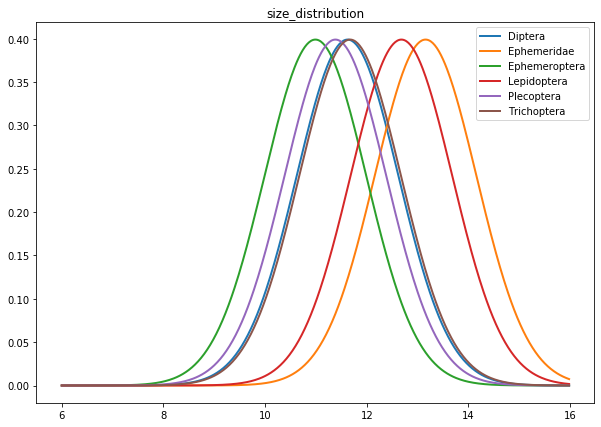

In [23]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()

### (2) average and match mu

In [24]:
def average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=False):
    """
        match mu to average
        calculate mu, sigma for each insect size distribution
        Args:
            - insect_size_dic: dict, {label_name: size_array}
            - mu: np.array(dtype=float), shape == [class_num]
            - sigma: np.array(dtype=float), shape == [class_num]
            - lbl_to_name: dict, {label: label_name}
            - keep_sigma: bool
    """
    mu_average = mu.mean()
    
    gmm = GMM(n_components=1, covariance_type="spherical")
    mu_converted = []
    sigma_converted = []
    for key, value in lbl_to_name.items():
        x = np.log2(insect_size_dic[value])
        if keep_sigma is True:
            x_convert = x + (mu_average - mu[key])
        else:
            x_convert = (x - mu[key]) / sigma[key]
            x_convert += mu_average
        gmm.fit(x_convert.reshape(-1, 1))
        mu_converted.append(gmm.means_.reshape([-1])[0])
        sigma_converted.append(np.sqrt(gmm.covariances_)[0])
    return np.array(mu_converted), np.array(sigma_converted)

- sigma = 1

In [25]:
mu_converted, sigma_converted = average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=False)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.917155719433476, sigma = 1.0000003306338987
name = Ephemeridae: mu = 11.917155719433474, sigma = 0.999999159344657
name = Ephemeroptera: mu = 11.917155719433474, sigma = 1.0000001735198656
name = Lepidoptera: mu = 11.917155719433476, sigma = 1.0000001952882904
name = Plecoptera: mu = 11.917155719433476, sigma = 0.9999997283549716
name = Trichoptera: mu = 11.917155719433472, sigma = 0.9999997705277399


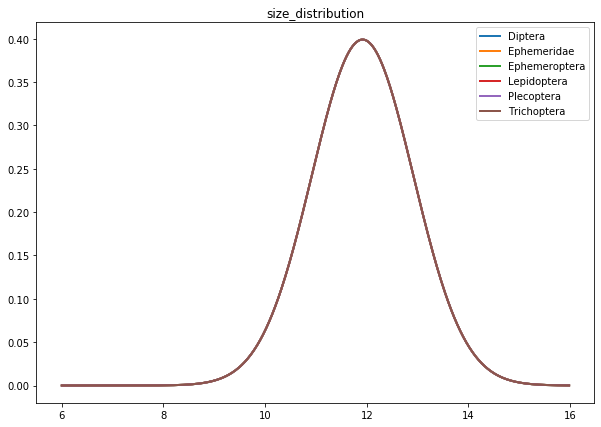

In [26]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()

- sigma = keep

In [27]:
mu_converted, sigma_converted = average_and_match_mu(insect_size_dic, mu, sigma, lbl_to_name, keep_sigma=True)
for key, value in lbl_to_name.items():
    print("name = {}: mu = {}, sigma = {}".format(value, mu_converted[key], sigma_converted[key]))

name = Diptera: mu = 11.917155719433476, sigma = 1.7181926510995689
name = Ephemeridae: mu = 11.917155719433474, sigma = 0.6106979826352166
name = Ephemeroptera: mu = 11.917155719433474, sigma = 1.237532505380425
name = Lepidoptera: mu = 11.917155719433476, sigma = 1.2809743800315292
name = Plecoptera: mu = 11.917155719433476, sigma = 0.804963562079924
name = Trichoptera: mu = 11.917155719433472, sigma = 0.8279052362708523


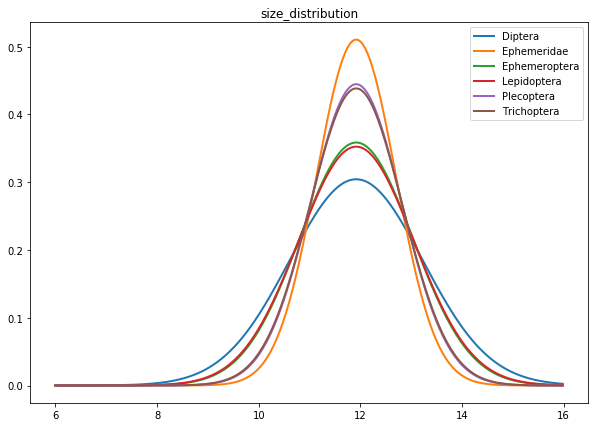

In [28]:
plt.figure(figsize=(10,7))
plt.plot(seq, gaussian(mu_converted[0], sigma_converted[0])(seq), linewidth=2, label="Diptera")
plt.plot(seq, gaussian(mu_converted[1], sigma_converted[1])(seq), linewidth=2, label="Ephemeridae")
plt.plot(seq, gaussian(mu_converted[2], sigma_converted[2])(seq), linewidth=2, label="Ephemeroptera")
plt.plot(seq, gaussian(mu_converted[3], sigma_converted[3])(seq), linewidth=2, label="Lepidoptera")
plt.plot(seq, gaussian(mu_converted[4], sigma_converted[4])(seq), linewidth=2, label="Plecoptera")
plt.plot(seq, gaussian(mu_converted[5], sigma_converted[5])(seq), linewidth=2, label="Trichoptera")
plt.title("size_distribution")
plt.legend()